In [65]:
!pip install torch_geometric


[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Cargar el dataset

In [66]:
import json
import networkx as nx
import os
import os.path as osp
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.data import InMemoryDataset, download_url
from torch_geometric.utils.convert import from_networkx
from zipfile import ZipFile

class TournamentDataset(InMemoryDataset):

    TORUNAMENT_URL = 'https://drive.upm.es/s/WTBtQ3HH2GjpGAi/download'

    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0], weights_only=False)
        self.train_idx = torch.load(self.processed_paths[1], weights_only=False)
        self.test_idx = torch.load(self.processed_paths[2], weights_only=False)

    @property
    def raw_file_names(self):
        return ['nx_graphs.zip']

    @property
    def processed_file_names(self):
        return ['geometric_data_processed.pt', "train_idx.pt", "test_idx.pt"]

    @property
    def num_classes(self):
        return 1

    @property
    def num_features(self):
        return 9

    def download(self):
        download_url(self.TORUNAMENT_URL, self.raw_dir, filename='nx_graphs.zip')

    def process(self):

        with ZipFile(self.raw_paths[0], 'r') as zip_ref:
            zip_ref.extractall(self.raw_dir)

        data_list = []
        train_idx = []
        test_idx = []
        for f in os.listdir(osp.join(self.raw_dir, "nx_graphs")):
            G = nx.read_gml(osp.join(self.raw_dir, "nx_graphs", f))
            data = from_networkx(G)
            data.x = data.x.float()

            data.nid = torch.tensor([G.graph["molecule_id"]], dtype=torch.long)
            data_list.append(data)

            if G.graph["set"] == "training":
                data.y = torch.tensor([G.graph["y"]], dtype=torch.float)
                train_idx.append(G.graph["molecule_id"])
            else:
                data.y = torch.tensor([torch.nan], dtype=torch.float)
                test_idx.append(G.graph["molecule_id"])

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data_list.sort(key=lambda x: x.nid.item())

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])
        torch.save(train_idx, self.processed_paths[1])
        torch.save(test_idx, self.processed_paths[2])

Number of molecules: 4200
Number of node attributes: 9
Example Graph: Data(x=[22, 9], edge_index=[2, 50], y=[1], molecule_id=[1], set='training', nid=[1])
Training set size: 3360
Test set size: 840
Trainning distribution: count    3360.000000
mean        2.200554
std         1.199276
min        -1.500000
25%         1.437500
50%         2.360000
75%         3.100000
max         4.500000
dtype: float64
Test distribution: Counter({'nan': 840})


Text(0.5, 1.0, 'Histogram of training labels')

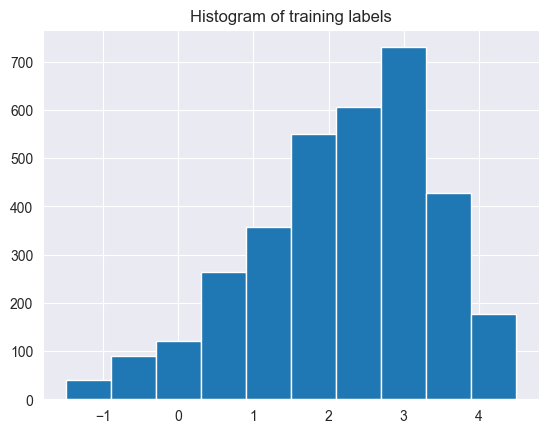

In [67]:
from collections import Counter
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")

dataset = TournamentDataset(root='tournament')

print(f"Number of molecules: {len(dataset)}")
print(f"Number of node attributes: {dataset.num_features}")
print(f"Example Graph: {dataset[0]}")
print(f"Training set size: {len(dataset.train_idx)}")
print(f"Test set size: {len(dataset.test_idx)}")
print(f"Trainning distribution: {pd.Series([dataset[i].y.item() for i in dataset.train_idx]).describe()}")
print(f"Test distribution: {Counter([str(dataset[i].y.item()) for i in dataset.test_idx])}")

pd.Series([dataset[i].y.item() for i in dataset.train_idx]).hist()
plt.title("Histogram of training labels")

# Dividir datos

In [68]:
import pandas as pd
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split

train_idx, val_idx = train_test_split(dataset.train_idx, test_size=0.15)

train_loader = DataLoader(dataset[train_idx], batch_size=512, shuffle=True)
val_loader = DataLoader(dataset[val_idx], batch_size=len(val_idx))

print(f"Number of training graphs: {len(train_idx)}, labels {pd.Series([dataset[i].y.item() for i in train_idx]).describe()}")
print(f"Number of validation graphs: {len(val_idx)}, labels {pd.Series([dataset[i].y.item() for i in val_idx]).describe()}")

Number of training graphs: 2856, labels count    2856.000000
mean        2.215893
std         1.186683
min        -1.480000
25%         1.467500
50%         2.380000
75%         3.100000
max         4.500000
dtype: float64
Number of validation graphs: 504, labels count    504.000000
mean       2.113631
std        1.265998
min       -1.500000
25%        1.292500
50%        2.255000
75%        3.100000
max        4.460000
dtype: float64


# Funciones de control

Se añade EarlyStopping para saber cuando el modelo alcanza su error más bajo y una función para validar en cada epoch en vez de validar solo al final como ocurría antes. Esto nos permite saber si el modelo realmente está aprendiendo.

También se ha añadido un checkpoint para garantizar la mejor versión del modelo.

In [69]:
class EarlyStopping:
    def __init__(self, patience=30, path='best_model.pt'):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.path = path

    def __call__ (self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        
        elif score < self.best_score:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
    
    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss
    
def validate_epoch():
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            y_pred = model(data).view(-1)
            y_true = data.y.view(-1)
            loss = criterion(y_pred, y_true)
            val_loss += loss.item()
    
    return val_loss / len(val_loader)


# Definir modelo

In [70]:
from torch.nn import Module
from torch_geometric.nn import GCN, GATv2Conv, MLP, global_add_pool, global_mean_pool, global_max_pool

class GAT(Module):
    def __init__(self, num_features, num_classes, hidden_channels=128):
        super(GAT, self).__init__()
        
        #Capa 1: para capturar diferentes relaciones químicas
        self.conv1 = GATv2Conv(num_features, hidden_channels, heads=4, dropout=0.2)
        #Capa 2: para profundizar en la estructura
        self.conv2 = GATv2Conv(hidden_channels * 4, hidden_channels, heads=4, dropout=0.2)
        #Capa 3: Salida de grafos 
        self.conv3 = GATv2Conv(hidden_channels * 4, hidden_channels, heads=1, concat=False)

        # MEJORA: MLP de salida más profundo y robusto
        self.cls = MLP(
            in_channels=hidden_channels * 2, #Multiplicamos por 2 por el pooling mean + max
            hidden_channels=hidden_channels,
            out_channels=num_classes,
            num_layers=3,
            dropout=0.3
        )

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Paso por las capas de atención
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv3(x, edge_index).relu()

        # MEJORA DE POOLING: Usamos la media Y el máximo de los nodos (da una visión global de la molécula)
        x_mean = global_mean_pool(x, batch)
        x_max = global_max_pool(x, batch)
        x = torch.cat([x_mean, x_max], dim=1) 

        x = self.cls(x)
        return x

'''
class GCNGraph(Module):

    def __init__(self, num_features, num_classes, hidden_channels=64, n_layers=3):
        super(GCNGraph, self).__init__()
        self.gcn = GCN(
            in_channels=num_features,
            hidden_channels=hidden_channels,
            num_layers=n_layers,
            out_channels=hidden_channels,
            dropout=0.5
        )
        self.cls = MLP(
            in_channels=hidden_channels,
            hidden_channels=hidden_channels,
            out_channels=num_classes,
            num_layers=2,
            dropout=0.5
        )

    def reset_parameters(self):
        self.gcn.reset_parameters()
        self.cls.reset_parameters()

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.gcn(x.float(), edge_index)
        x = global_add_pool(x, batch)
        x = self.cls(x)
        return x
'''

'\nclass GCNGraph(Module):\n\n    def __init__(self, num_features, num_classes, hidden_channels=64, n_layers=3):\n        super(GCNGraph, self).__init__()\n        self.gcn = GCN(\n            in_channels=num_features,\n            hidden_channels=hidden_channels,\n            num_layers=n_layers,\n            out_channels=hidden_channels,\n            dropout=0.5\n        )\n        self.cls = MLP(\n            in_channels=hidden_channels,\n            hidden_channels=hidden_channels,\n            out_channels=num_classes,\n            num_layers=2,\n            dropout=0.5\n        )\n\n    def reset_parameters(self):\n        self.gcn.reset_parameters()\n        self.cls.reset_parameters()\n\n    def forward(self, data):\n        x, edge_index, batch = data.x, data.edge_index, data.batch\n\n        x = self.gcn(x.float(), edge_index)\n        x = global_add_pool(x, batch)\n        x = self.cls(x)\n        return x\n'

# Entrenar el modelo

In [71]:
import torch

def train():
  model.train()
  total_loss = 0

  for data in train_loader:
    data = data.to(device)
    optimizer.zero_grad()

    y_true = data.y.view(-1)
    y_pred = model(data).view(-1)

    loss = criterion(y_pred, y_true)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

  return total_loss / len(train_loader)

device = "cuda" if torch.cuda.is_available() else "cpu"

model = GAT(dataset.num_features, 1)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
criterion = torch.nn.HuberLoss()

#Se añade scheduler para redur el LR automaticamente en caso de que no baje la pérdida
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.5, patience = 10)

#Se crea una instancia del Early Stopping creado anteriormente
early_stopping = EarlyStopping(patience = 25)

for epoch in range(300):
    train_loss = train()
    val_loss = validate_epoch()

    scheduler.step(val_loss)
    early_stopping(val_loss, model)

    if epoch % 10 == 0:
      act_lr = optimizer.param_groups[0]['lr']
      print(f'Epoch: {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {act_lr:.6f}')
    
    if early_stopping.early_stop:
      print(f"Parada temprana en epoch {epoch}. Guardando mejor modelo.")
      break

model.load_state_dict(torch.load('best_model.pt'))

Epoch: 0, Train Loss: 1.6738, Val Loss: 1.7092, LR: 0.001000
Epoch: 10, Train Loss: 0.5502, Val Loss: 0.7472, LR: 0.001000
Epoch: 20, Train Loss: 0.5151, Val Loss: 0.9981, LR: 0.001000
Epoch: 30, Train Loss: 0.4799, Val Loss: 1.2083, LR: 0.001000
Epoch: 40, Train Loss: 0.4348, Val Loss: 1.1214, LR: 0.000500
Epoch: 50, Train Loss: 0.4147, Val Loss: 0.4244, LR: 0.000500
Epoch: 60, Train Loss: 0.3951, Val Loss: 0.4307, LR: 0.000500
Epoch: 70, Train Loss: 0.3439, Val Loss: 0.5793, LR: 0.000500
Epoch: 80, Train Loss: 0.3293, Val Loss: 0.3536, LR: 0.000500
Epoch: 90, Train Loss: 0.2911, Val Loss: 0.4515, LR: 0.000500
Epoch: 100, Train Loss: 0.2727, Val Loss: 0.3332, LR: 0.000500
Epoch: 110, Train Loss: 0.2601, Val Loss: 0.2844, LR: 0.000250
Epoch: 120, Train Loss: 0.2399, Val Loss: 0.4902, LR: 0.000250
Epoch: 130, Train Loss: 0.2317, Val Loss: 0.3228, LR: 0.000125
Epoch: 140, Train Loss: 0.2328, Val Loss: 0.2912, LR: 0.000125
Epoch: 150, Train Loss: 0.2268, Val Loss: 0.3127, LR: 0.000125
Epo

<All keys matched successfully>

# Validación

RMSE: 0.7062549975004045


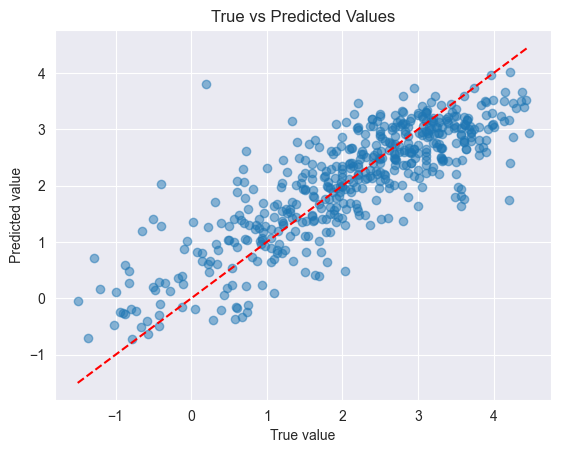

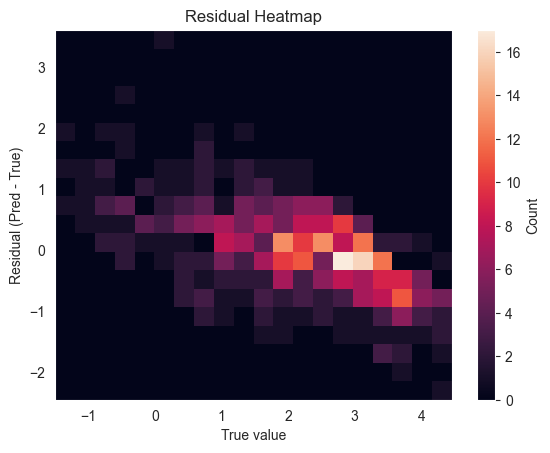

In [72]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error

def test():
    model.eval()

    y_pred = []
    y_true = []
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)

            out = model(data)
            y_hat = out.view(-1)

            y_pred.extend(y_hat.cpu().tolist())
            y_true.extend(data.y.tolist())
    return y_true, y_pred

y_true, y_pred = test()
print(f"RMSE: {root_mean_squared_error(y_true, y_pred)}")

def plot_residual_heatmap(y_true, y_pred, n_bins=20):
    residuals = y_pred - y_true

    plt.figure()
    plt.hist2d(y_true, residuals, bins=n_bins)
    plt.colorbar(label="Count")
    plt.xlabel("True value")
    plt.ylabel("Residual (Pred - True)")
    plt.title("Residual Heatmap")
    plt.show()

def plot_true_vs_pred(y_true, y_pred):
    plt.figure()
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
    plt.xlabel("True value")
    plt.ylabel("Predicted value")
    plt.title("True vs Predicted Values")
    plt.show()

plot_true_vs_pred(np.array(y_true).flatten(), np.array(y_pred).flatten())
plot_residual_heatmap(np.array(y_true).flatten(), np.array(y_pred).flatten(), n_bins=20)



# Generar solución para el torneo


In [73]:
device = "cpu"

loader = DataLoader(dataset[dataset.test_idx], batch_size=len(dataset.test_idx))
model.eval()
model.to(device)

predictions = []
with torch.no_grad():
    for data in loader:
        data = data.to(device)
        out = model(data)
        for i, nid in enumerate(data.nid.cpu().tolist()):
            predictions.append({"nid": nid, "y": out[i].cpu().item()})


df_predictions = pd.DataFrame(predictions)

file_path = "test_predictions.json"
with open(file_path, 'w') as f:
    json.dump({'nid': df_predictions['nid'].tolist(), 'y': df_predictions['y'].tolist()}, f, indent=4)

# Evaluación del modelo

RMSE Final en Test (840 moléculas): 0.815391

Gráficos de rendimiento sobre el Test:


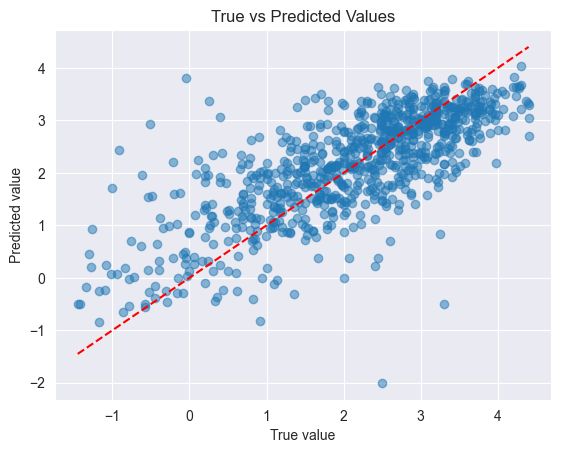

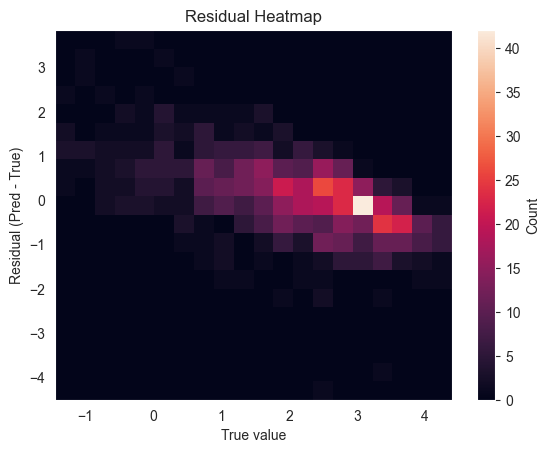

In [74]:
import pandas as pd
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

df_etiquetas = pd.read_csv('test_labels.csv')
df_eval = df_predictions.merge(df_etiquetas, left_on='nid', right_on='id')

rmse_final = root_mean_squared_error(df_eval['label'], df_eval['y'])
print(f"RMSE Final en Test (840 moléculas): {rmse_final:.6f}")

y_real_test = df_eval['label'].values
y_pred_test = df_eval['y'].values

print("\nGráficos de rendimiento sobre el Test:")

plot_true_vs_pred(y_real_test, y_pred_test)
plot_residual_heatmap(y_real_test, y_pred_test, n_bins=20)